# Mobile app user behavior analysis

You work in a startup that sells food. You need to figure out how your mobile app users behave.

**Data description:**

Each log entry in `/datasets/logs_exp.csv` is a user action, or event.
- `EventName` is the name of the event;
- `DeviceIDHash` - a unique user ID;
- `EventTimestamp` - time of the event;
- `ExpId` - experiment number: 246 and 247 - control groups, and 248 - experimental group.

**Plan of work for this project:**
1. Data review and preprocessing;
2. Construction and analysis of the sales funnel;
3. Conducting a study of the results of the A/A/B experiment (changing fonts throughout the application);
4. analyzing the results;
5. Formulation of conclusions.

## Uploading and preparing data for analysis

In [72]:
# library imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import datetime as dt
import scipy.stats as stats
import warnings

from scipy import stats as st
from plotly import graph_objects as go

In [73]:
# ignore warnings
warnings.filterwarnings(action='ignore')
# restriction to display decimal places
pd.options.display.float_format = '{:,.4f}'.format

In [74]:
# uploading data
data = pd.read_csv('/content/logs_exp.csv', sep='\t')

In [75]:
# dataframe review
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


In [76]:
data.sample(10)

,EventName,DeviceIDHash,EventTimestamp,ExpId
81900,OffersScreenAppear,9182444363400946277,1564821790,247
151561,CartScreenAppear,1100007125648169445,1564999451,248
112812,CartScreenAppear,3520574609868748885,1564903500,246
196225,MainScreenAppear,2336714371076846454,1565099283,246
233129,CartScreenAppear,1055544042902443290,1565190454,246
242357,PaymentScreenSuccessful,518781617060869985,1565206048,246
209300,MainScreenAppear,742351075583407193,1565117710,247
40134,MainScreenAppear,318519419647317031,1564709406,248
132765,PaymentScreenSuccessful,5017771502001278918,1564936497,246
124732,CartScreenAppear,8149552824213934775,1564923323,247


In [77]:
# display unique values in the columns
print(data['EventName'].unique())
print(data['ExpId'].unique())

['MainScreenAppear' 'PaymentScreenSuccessful' 'CartScreenAppear'
 'OffersScreenAppear' 'Tutorial']
[246 248 247]


In [78]:
# search for duplicates in the data
duplicate = data.duplicated().sum()

print(f'Number of duplicates in dataframe: {duplicate}')
print(f'Percentage of duplicates in dataframe: {round((duplicate / len(data))*100, 2)}%')

# search for gaps in the data
print('Number of gaps in the data:', data.isnull().sum())

Number of duplicates in dataframe: 413
Percentage of duplicates in dataframe: 0.17%
Number of gaps in the data: EventName         0
DeviceIDHash      0
EventTimestamp    0
ExpId             0
dtype: int64


**Conclusion:**

- Number of columns: ***4***
- Number of rows: ***244126***
- The data type in the columns: ***int64(3), object(1)***
- Missing values ***none***
- Full duplicates ***413***
- No abnormal values detected

You should fix the column names to be more readable, you should get rid of the duplicates and also change the data type in the *EventTimestamp* column (date and time are in seconds). For ease of further analysis, we will put the date in a separate column.

## Preprocessing data

In [79]:
# rename colunms
data = data.rename(columns={'EventName': 'event', 'DeviceIDHash': 'user_id', 
                            'EventTimestamp': 'date_time', 'ExpId': 'group_id'})

# date_time data type replacement: 
data['date_time'] = pd.to_datetime(data['date_time'], unit='s')

# adding a field with a date:
data['date'] = pd.to_datetime(data['date_time'].dt.date)
data.sample(10)

,event,user_id,date_time,group_id,date
158632,MainScreenAppear,7824677770403633962,2019-08-05 13:12:19,248,2019-08-05
132841,MainScreenAppear,4579852380286911008,2019-08-04 16:38:13,248,2019-08-04
17805,PaymentScreenSuccessful,1897094419292783753,2019-08-01 12:00:10,247,2019-08-01
85454,OffersScreenAppear,328146365833208502,2019-08-03 10:16:15,248,2019-08-03
163392,MainScreenAppear,3520574609868748885,2019-08-05 14:57:29,246,2019-08-05
91482,CartScreenAppear,7003124882657797758,2019-08-03 12:46:35,246,2019-08-03
81375,CartScreenAppear,7065239911766460173,2019-08-03 08:24:49,246,2019-08-03
127390,MainScreenAppear,6245072566613457739,2019-08-04 14:11:29,248,2019-08-04
131594,CartScreenAppear,6992868177979592023,2019-08-04 16:02:58,246,2019-08-04
177514,OffersScreenAppear,2158185118578389474,2019-08-06 02:05:52,246,2019-08-06


In [80]:
# remove duplicates
print('Lines to process:', len(data))
data = data.drop_duplicates().reset_index(drop=True)
print('Lines after processing:', len(data))

Lines to process: 244126
Lines after processing: 243713


In [81]:
# correction check
data.info()
data.sample(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243713 entries, 0 to 243712
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   event      243713 non-null  object        
 1   user_id    243713 non-null  int64         
 2   date_time  243713 non-null  datetime64[ns]
 3   group_id   243713 non-null  int64         
 4   date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 9.3+ MB


,event,user_id,date_time,group_id,date
29394,MainScreenAppear,1903640604628777664,2019-08-01 16:34:03,248,2019-08-01
44076,OffersScreenAppear,935788065062565859,2019-08-02 06:16:39,248,2019-08-02
152290,CartScreenAppear,1919610389675188301,2019-08-05 10:29:15,246,2019-08-05
185127,PaymentScreenSuccessful,3383558428248432049,2019-08-06 08:15:44,246,2019-08-06
81195,MainScreenAppear,448322291576601609,2019-08-03 08:23:27,246,2019-08-03
61048,MainScreenAppear,1604710148973774560,2019-08-02 14:40:03,246,2019-08-02
3553,CartScreenAppear,9182444363400946277,2019-08-01 02:56:02,247,2019-08-01
7239,MainScreenAppear,7224691986599895551,2019-08-01 06:43:57,246,2019-08-01
90301,MainScreenAppear,4264669332280703345,2019-08-03 12:17:47,247,2019-08-03
133771,MainScreenAppear,5530821733261873312,2019-08-04 17:08:35,248,2019-08-04


We will also check whether users in the groups overlap. If there are such users, it may affect the purity of the further experiment.

In [82]:
data.groupby('user_id')['group_id'].nunique().reset_index().query('group_id > 1')

,user_id,group_id


We will also look at the start and end dates of the test in each experimental group:

In [83]:
start = data.groupby('group_id')['date_time'].min()
finish = data.groupby('group_id')['date_time'].max()
first = data.groupby('group_id')['date_time'].describe()

print('Date of first log entry by group:', start)
print(' ')
print('Date of last entry in the log by group:', finish)

first

Date of first log entry by group: group_id
246   2019-07-25 04:43:36
247   2019-07-25 20:31:42
248   2019-07-25 11:28:47
Name: date_time, dtype: datetime64[ns]
 
Date of last entry in the log by group: group_id
246   2019-08-07 21:15:17
247   2019-08-07 21:12:25
248   2019-08-07 21:10:08
Name: date_time, dtype: datetime64[ns]


,count,unique,top,freq,first,last
group_id,,,,,,
246,80181,66582,2019-08-01 13:06:35,7,2019-07-25 04:43:36,2019-08-07 21:15:17
247,77950,65712,2019-08-04 16:23:19,8,2019-07-25 20:31:42,2019-08-07 21:12:25
248,85582,71929,2019-08-05 12:47:50,7,2019-07-25 11:28:47,2019-08-07 21:10:08


Each group began and ended testing on the same dates, which were July 25, 2019 to August 07, 2019.

Thus, during data processing, the following errors were eliminated:
1. Column names were made readable and understandable;
2. The data type in `date_time` column was corrected;
3. Separate column for date was created;
4. Removed duplicates, as their percentage of the total data is less than 1%, and their removal will not affect further research;
5. Additional checking of users in groups was done;
6. Identified the start and end dates of testing by group.

## Data research and verification

### Number of events in log

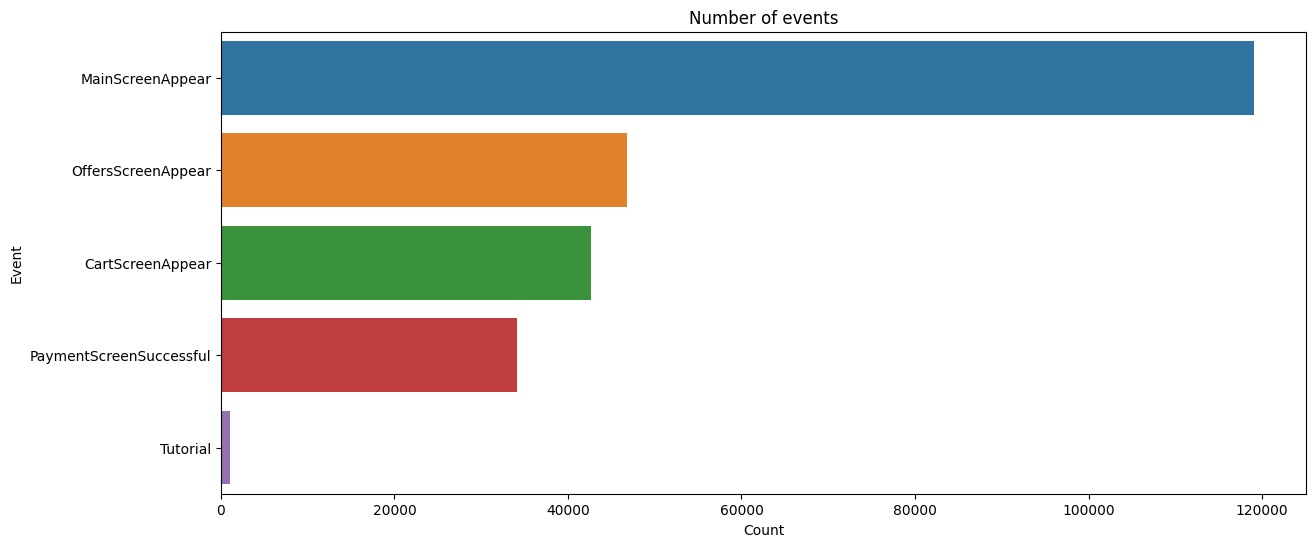

,Event,Count
1,MainScreenAppear,119101
2,OffersScreenAppear,46808
0,CartScreenAppear,42668
3,PaymentScreenSuccessful,34118
4,Tutorial,1018


Number of tracked events: 5
Number of records for these events: 243713


In [84]:
# counting the number of records for each event
event_count = data.groupby('event').agg({'date_time':'count'}).reset_index().sort_values(by='date_time', 
                                                                                         ascending=False)
event_count.columns = ['Event', 'Count']

# graph the number of entries for each event
plt.figure(figsize=(14, 6))
plt.title('Number of events')
sns.barplot(x='Count', y='Event', data=event_count)
plt.show()

display(event_count)
print('Number of tracked events:', len(event_count))
print('Number of records for these events:', len(data))

**Conclusion:**

1. The most frequently called event in the application is *MainScreenAppear* - the main application screen, this event has been called 119101 times;
2. The least frequently called event in the application is *Tutorial* - lesson, this event was called only 1018 times;
3. The key event for the app - *PaymentScreenSuccessful* - Payment Successful screen, it was called 34118 times.

### Number of users in the log

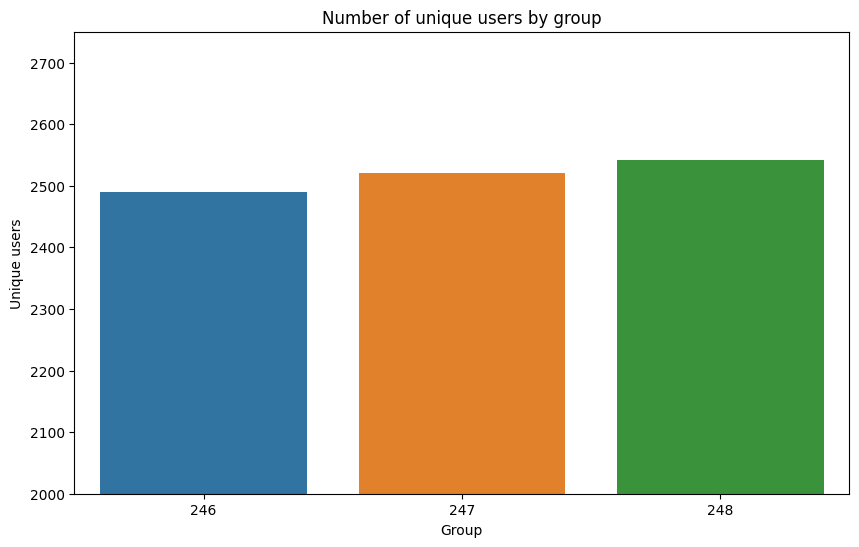

Number of unique users:
 In group 246 is 2489
 In group 247 is 2520
 In group 248 is 2542
Total 7551


In [85]:
# counting the number of users in each group
user_count = data.groupby('group_id').agg({'user_id':'nunique'}).reset_index()
user_count.columns = ['Group', 'Unique users']

# graph the number of users in each group
plt.figure(figsize=(10, 6))
plt.title('Number of unique users by group')
sns.barplot(y='Unique users', x='Group', data=user_count).set_ylim(2000, 2750)
plt.show()

print('Number of unique users:')
print(' In group 246 is', user_count.iloc[0]['Unique users'])
print(' In group 247 is', user_count.iloc[1]['Unique users'])
print(' In group 248 is', user_count.iloc[2]['Unique users'])
print('Total', user_count['Unique users'].sum())

**Conclusion:**

The total number of unique users in the log of 7551 people of them:

- In 246 group: 2489 people
- In 247 group: 2520 people
- In 248 group: 2542 people

### Average number of events per user

count   7,551.0000
mean       32.2756
std        65.1542
min         1.0000
25%         9.0000
50%        20.0000
75%        37.0000
max     2,307.0000
Name: event_count, dtype: float64


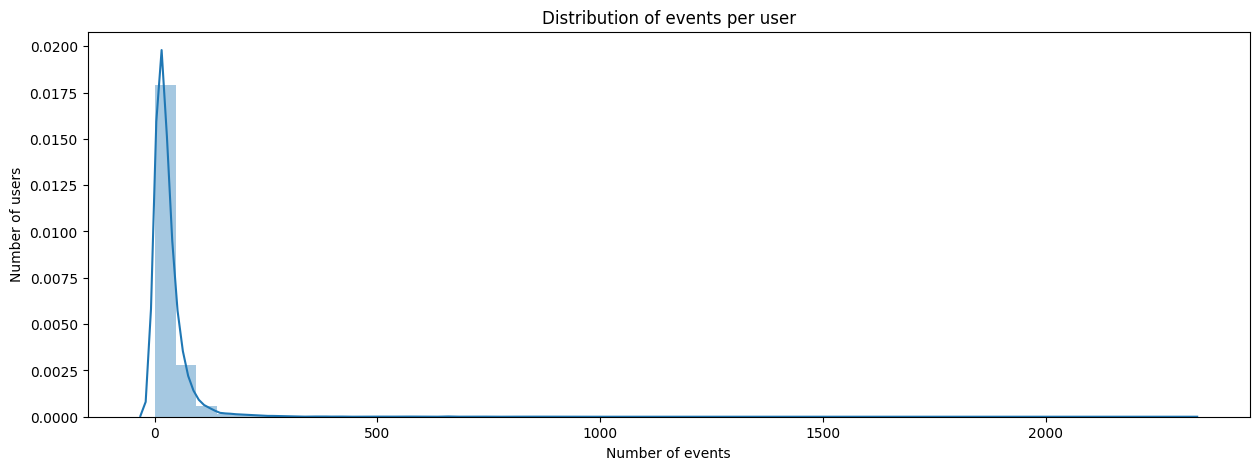

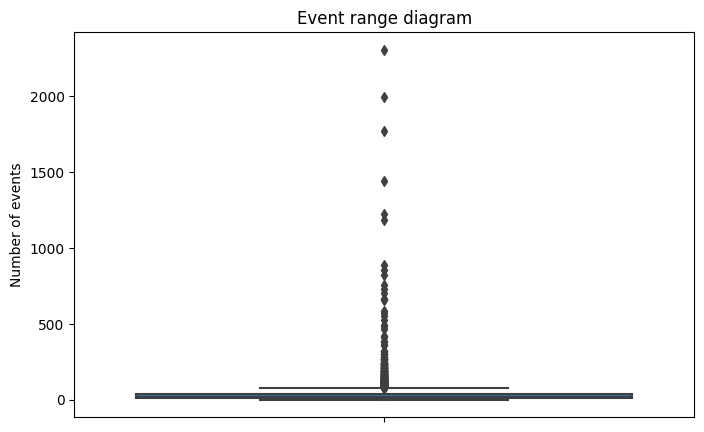

99% of users commit no more than 200.5 events


In [86]:
# counts the average number of events per user:
events_by_user = data.groupby('user_id').agg(event_count = ('event', 'count')).reset_index()

print(events_by_user['event_count'].describe())

# graph of the distribution of the number of events per user
plt.figure(figsize=(15, 5))
plt.title('Distribution of events per user', loc='center')
sns.distplot(events_by_user['event_count'], bins=50)
plt.xlabel('Number of events')
plt.ylabel('Number of users')
plt.show()

# diagram of the spread of the number of events per user
plt.figure(figsize=(8, 5))
plt.title('Event range diagram')
sns.boxplot(y='event_count', data=events_by_user).set(xlabel='', ylabel='Number of events')
plt.xticks(rotation=45)
plt.show()

print('99% of users commit no more than', events_by_user['event_count'].quantile(0.99), 'events')

**Conclusion:**

On average, there are about 32 events per user. At the same time, the minimum number is only one, and the maximum is 2307 events. If we talk about the median - it is 20 events per user.

All values that exceed 200 events can be considered anomalous emissions, from which it is necessary to get rid of.

In [87]:
# list of users with an abnormal number of events
anomaly_user_id = list(events_by_user.query('event_count > 200')['user_id'])
print('Number of lines:')
print(' before processing', len(data), 'lines')
# remove all records with users from the 'anomaly_user_id' list
clear_data = data.query('user_id not in @anomaly_user_id') 
print(' after processing', len(clear_data), 'lines')
print('Deleted', '{:.2%}'.format((len(data) - len(clear_data)) / len(data)))

Number of lines:
 before processing 243713 lines
 after processing 209333 lines
Deleted 14.11%


In [88]:
# counting the average number of events per user after anomaly removal
clear_events_by_user = clear_data.groupby('user_id').agg(event_count = ('event', 'count')).reset_index()
print(clear_events_by_user['event_count'].describe())

print('On average one user commits', 
      int(clear_events_by_user['event_count'].mean()), 'events')

count   7,475.0000
mean       28.0044
std        27.7984
min         1.0000
25%         9.0000
50%        19.0000
75%        37.0000
max       199.0000
Name: event_count, dtype: float64
On average one user commits 28 events


**Conclusion:**.

After processing the anomalies, the average number of events per user shifted to 28 events.

### Determining the time interval of analysis

In [89]:
print(clear_data['date_time'].describe())

print('Date of first log entry', clear_data['date_time'].min())
print('Date of last entry in the log', clear_data['date_time'].max())
print('Log period', clear_data['date_time'].max() - clear_data['date_time'].min())

count                  209333
unique                 156983
top       2019-08-04 16:23:19
freq                        9
first     2019-07-25 04:43:36
last      2019-08-07 21:15:17
Name: date_time, dtype: object
Date of first log entry 2019-07-25 04:43:36
Date of last entry in the log 2019-08-07 21:15:17
Log period 13 days 16:31:41


The data contain information from July 25, 2019 to August 07, 2019.

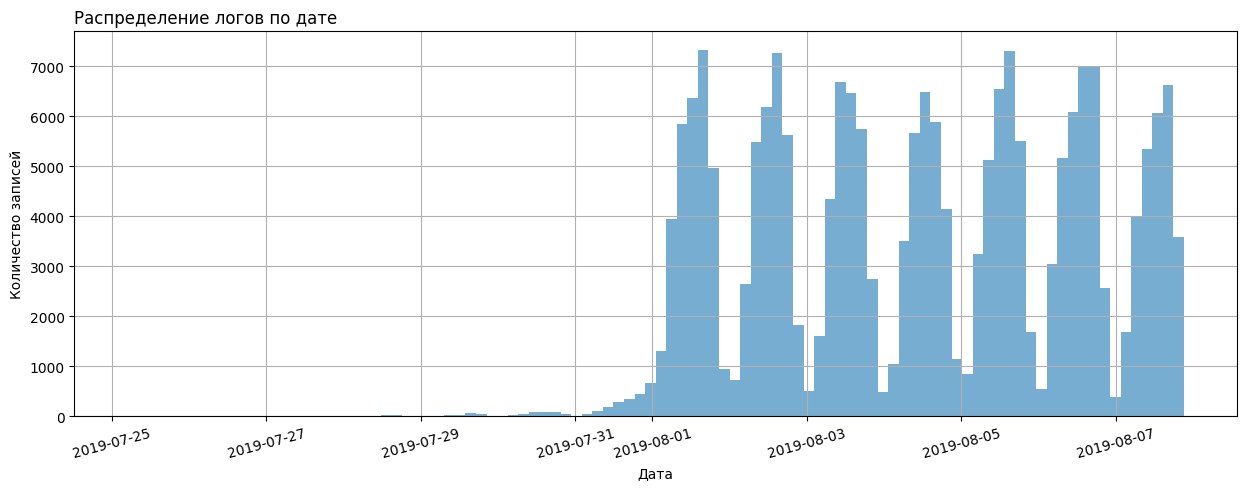

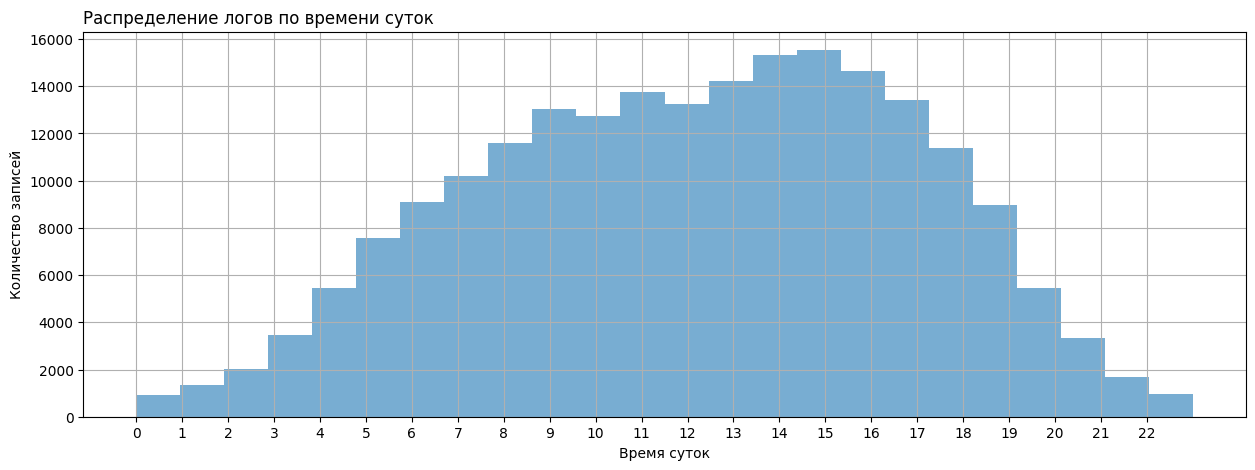

In [90]:
# histograms by date and time:
plt.title('Distribution of logs by date', loc='left')
plt.xlabel('Date')
plt.ylabel('Amount of logs')
clear_data['date_time'].hist(bins=100, xrot=15,  figsize=(15, 5), alpha=0.6)
plt.show()

plt.title('Distribution of logs by time of day', loc='left')
plt.xlabel('Time of day')
plt.ylabel('Amount of logs')
clear_data['date_time'].dt.hour.hist(bins=24, figsize=(15, 5), alpha=0.6)
plt.xticks(range(0, 23))
plt.show()

The histogram shows that in the first 6 days the number of records is extremely low, and starting from August 01, 2019 the number of records increases sharply. Thus, we can assume that only starting from August 1, 2019, a sufficient number of records begins to accumulate in the logs for event analysis, therefore, all records before that date can be ignored in further analysis, because they will distort the overall picture.

In [91]:
# filter dataset and leave records that were made later than 2019-07-31
clear_data = clear_data.query('date > "2019-07-31"')

print('The time period is from', clear_data['date_time'].min(), 'to', clear_data['date_time'].max())

The time period is from 2019-08-01 00:07:28 to 2019-08-07 21:15:17


After adjusting the time interval of the analysis, let us consider the daily analysis of the week we selected:

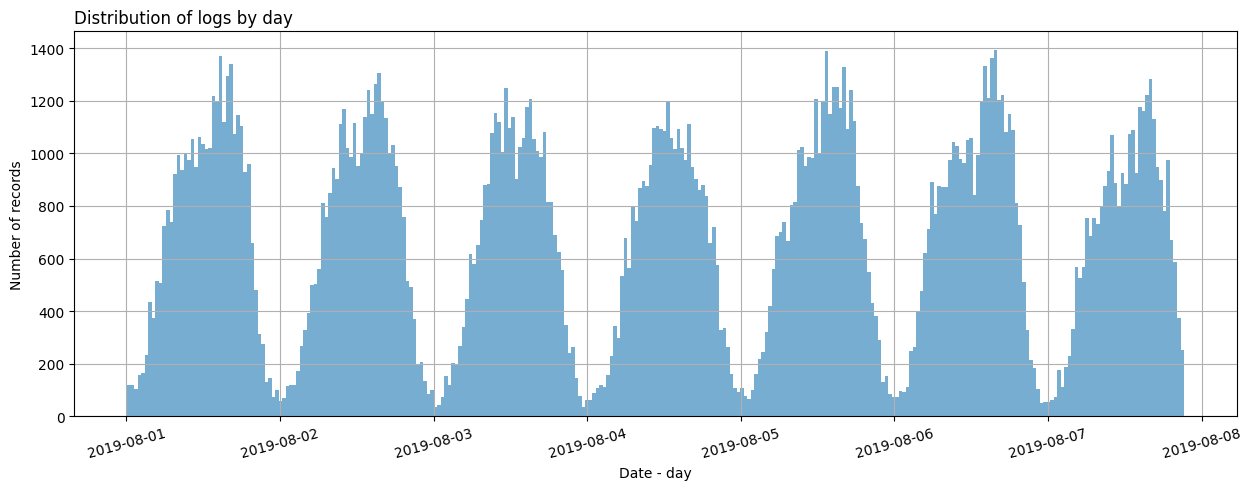

In [92]:
plt.title('Distribution of logs by day', loc='left')
plt.xlabel('Date - day')
plt.ylabel('Amount of logs')
clear_data['date_time'].hist(bins=300, xrot=15, figsize=(15, 5), alpha=0.6)
plt.show()

According to the obtained graph, you can see that the number of records by day is not exactly the same. For example, the maximum number of records fall on 1, 5, 6 days, namely on August 1, 5 and 6, 2019 - more than 1200 records were recorded. While August 3 and 4 noticeably decrease the number of records - do not exceed 1200.

So, after adjusting the time period, which is characterized by an extremely low number of records, we set a new time period for further analysis, and it is: from **2019-08-01 00:07:28 to 2019-08-07 21:15:17**

### Counting lost data in the study

In [93]:
before_logs = data.shape[0]
before_users = data['user_id'].nunique()

print('BEFORE period correction total events: %d, total users: %d.' % (before_logs, 
                                                                                before_users))
data = clear_data[clear_data['date_time'] >= '2019-08-01']
print()

print('AFTER period correction total events: %d, total users: %d.' % (data.shape[0], 
                                                                                   data['user_id'].nunique()))
print()


print('Changing the number of logs:', 
      data.shape[0]- before_logs, 
      '({:.1%})'.format((data.shape[0]-before_logs)/before_logs))
print('Change the number of users:', 
      data['user_id'].nunique()-before_users, 
      '({:.1%})'.format((data['user_id'].nunique()-before_users)/before_users))

BEFORE period correction total events: 243713, total users: 7551.

AFTER period correction total events: 206615, total users: 7458.

Changing the number of logs: -37098 (-15.2%)
Change the number of users: -93 (-1.2%)


### Counting the number of users in each experimental group

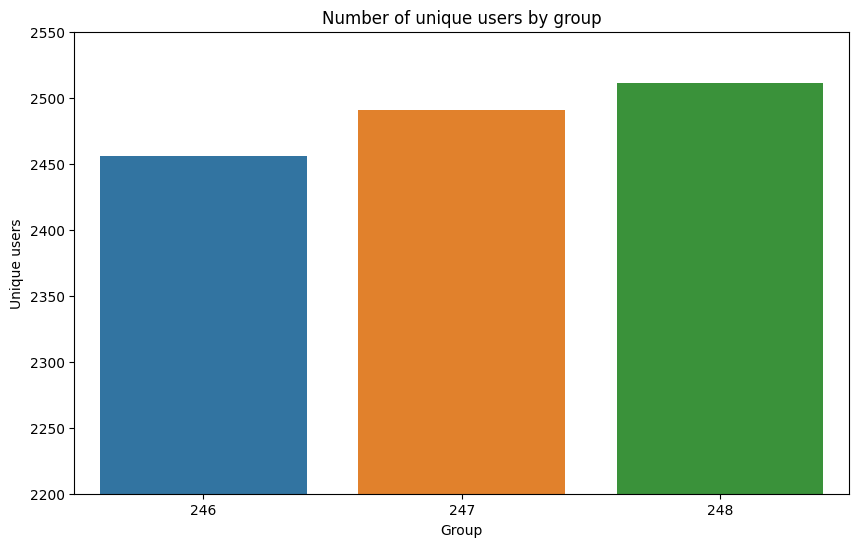

Number of unique users:
 In group 246 is 2456
 In group 247 is 2491
 In group 248 is 2511
Total 7458


,Group,Unique users,Number of users
0,246,2456,67412
1,247,2491,68295
2,248,2511,70908


In [94]:
# count the number of users in each group
user_count = data.groupby('group_id').agg({'user_id': ['nunique', 'count']}).reset_index()
user_count.columns = ['Group', 'Unique users', 'Number of users']

# graph the number of users in each group
plt.figure(figsize=(10, 6))
plt.title('Number of unique users by group')
sns.barplot(y='Unique users', x='Group', data=user_count).set_ylim(2200, 2550)
plt.show()

print('Number of unique users:')
print(' In group 246 is', user_count.iloc[0]['Unique users'])
print(' In group 247 is', user_count.iloc[1]['Unique users'])
print(' In group 248 is', user_count.iloc[2]['Unique users'])
print('Total', user_count['Unique users'].sum())
user_count

The number of users in the groups is generally comparable, the number of events is slightly different. Group 248 has the most users and events.

**Conclusion:**

After performing the data analysis, the following *key factors* were identified:

1. Identified the relevant time period for further analysis: 2019-08-01 00:07:28 to 2019-08-07 21:15:17
2. Number of unique users in each group:
   - In group 246: 2456 users
   - In group 247: 2491 users
   - In group 248: 2511 users
3. Average number of events per user in the application: 28 events

**Features of the events in the application:**
- The most frequently called event in the application is *MainScreenAppear* - the main application screen, this event has been called 119101 times;
- The least frequently called event in the application is *Tutorial* - the snub, this event has been called a total of 1018 times;
- The key event for the app - *PaymentScreenSuccessful* - Successful payment screen, was called 34118 times.

## Exploring the event funnel

### Event analysis and its frequency in logs

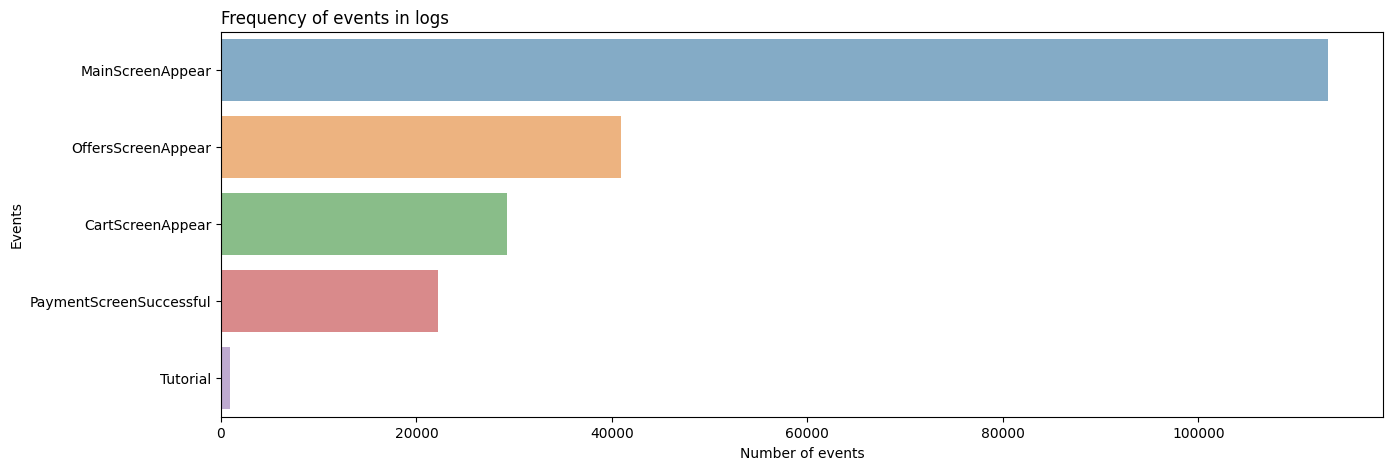

,event,total_events
1,MainScreenAppear,113264
2,OffersScreenAppear,40956
0,CartScreenAppear,29250
3,PaymentScreenSuccessful,22164
4,Tutorial,981


In [95]:
events = (data.
          groupby('event').
          agg({'user_id': 'count'}).
          reset_index().
          rename(columns={'user_id' : 'total_events'}).
          sort_values(by='total_events', ascending=False))
# график
plt.figure(figsize=(15, 5))
ax = sns.barplot(x='total_events', y='event', data=events, alpha=0.6, orient='h')
ax.set_title('Frequency of events in logs', loc='Left')
ax.set_xlabel('Number of events') 
ax.set_ylabel('Events')
plt.show()

events

Based on the data, we see that:
- `MainScreenAppear` (Home Screen) has been seen 113264 times;
- OffersScreenAppear` (catalog offers) seen 40956 times;
- The `CartScreenAppear` (product card) have seen 29250 times;
- The `PaymentScreenSuccessful` (Screen with confirmation of successful payment) seen 22164 times;
- The `Tutorial` has been viewed 981 times.

### Number of users who committed the event

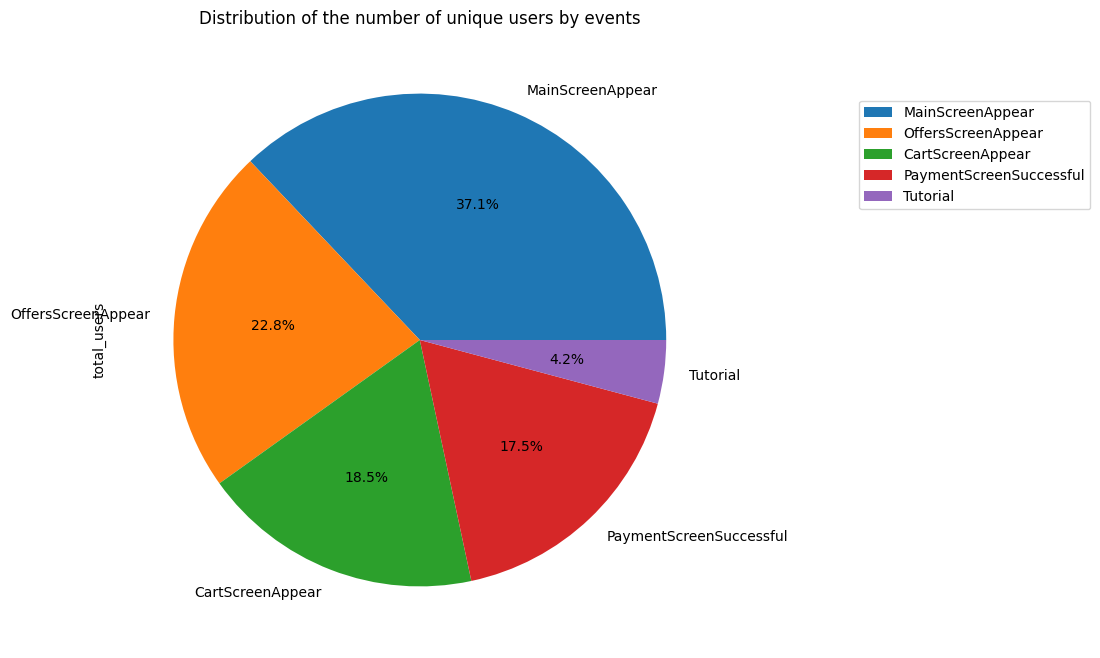

,total_users,percent
event,,
MainScreenAppear,7344,98.4714
OffersScreenAppear,4517,60.5658
CartScreenAppear,3658,49.0480
PaymentScreenSuccessful,3463,46.4334
Tutorial,824,11.0485


In [96]:
funnel = (data.
          groupby('event').
          agg({'user_id': 'nunique'}).
          rename(columns={'user_id' : 'total_users'}).
          sort_values(by='total_users', ascending=False))
funnel['percent'] = funnel['total_users'] / data['user_id'].nunique() * 100

# pie chart
funnel.plot(y="total_users", kind="pie", figsize=(8, 8), autopct='%1.1f%%')
plt.legend(bbox_to_anchor=(0.6, 0, 1, 0.9))
plt.title('Distribution of the number of unique users by events')
plt.show()
funnel

- The home page was viewed by 7344 users (98.47% of the total number of users) - almost all
- Offer catalog was viewed by 4517 users (60.57% of total number)
- Product cards were viewed by 3658 users (49.05% of total amount)
- 3463 users completed the payment (46.43% of total)
- The lesson was viewed by 824 users (11.05% of the total)

We can see that all events are lined up in a chain of actions, except for viewing the lesson (Tutorial). In order to view the lesson (instructions on how to use the application) it is not necessary to purchase something. Also, more often than not, the interface is intuitive. That's why we'll remove the Tutorial step from the rest of the chain.

Then the sequence of actions is as follows:

1. The main screen
2. Offerings catalog
3. Product card
Screen with confirmation of successful payment

### Calculating the event funnel

In [97]:
# table with the number of unique users for each event in each test group [246, 247, 248]
group_event_count = (
    data.query('event != "Tutorial"').groupby(['group_id', 'event'])
    .agg({'user_id':'nunique'}).reset_index().sort_values('user_id', ascending=False))

# Funnel of events by test group 
fig = go.Figure() 
for group_id in [246,247,248]:
    funnel = group_event_count.query('group_id ==@group_id')
    fig.add_trace(go.Funnel(name = group_id, y = funnel['event'], x = funnel['user_id'], 
                            orientation = "h", textinfo = "value+percent initial"))
    fig.update_layout(title='Funnel of events by group')
fig.show()

Thus, the following results are obtained:

- On average, 47% of the total number of users make a purchase and make a successful payment in the app.
- Most of all users are lost at the 2nd step of the funnel - OffersScreenAppear, i.e. this event is made by only 61% of the total number of users who made the previous event.
- At other steps of the funnel losses of users are not so serious.
- In general, the situation for each test group is identical, the difference between the groups is about 1-2%.

In [98]:
# counting the share of participants from the last step
count_users = data.pivot_table(index='user_id', columns='event', values='date_time', aggfunc='min')

print('Total visitors:', 
      '({:.1%})'.format(count_users['MainScreenAppear'].count() / count_users['MainScreenAppear'].count() ))
print('Viewed Directory as % of previous step:', 
      '({:.1%})'.format(count_users['OffersScreenAppear'].count() / count_users['MainScreenAppear'].count() ))
print('Viewed the Product Card in % of the previous step:', 
      '({:.1%})'.format(count_users['CartScreenAppear'].count() / count_users['OffersScreenAppear'].count()))
print('Paid in % of the previous step:',
      '({:.1%})'.format(count_users['PaymentScreenSuccessful'].count() / count_users['CartScreenAppear'].count()))

Total visitors: (100.0%)
Viewed Directory as % of previous step: (61.5%)
Viewed the Product Card in % of the previous step: (81.0%)
Paid in % of the previous step: (94.7%)


We see that most users were lost after the first step, with only 61% of users appearing on the Catalog screen and continuing their in-app purchase path.

## Study of experimental results

### Counting the number of users in groups

Previously, in section 3.6 we have already calculated and visualized the unique number of users by group after removing anomalies from the data. In this regard, we will display only the resulting numbers:

In [99]:
# count the number of users in each group
user_count = data.groupby('group_id').agg({'user_id': ['nunique', 'count']}).reset_index()
user_count.columns = ['group', 'Unique users', 'Number of users']
print('Number of unique users:')
print(' In group 246 is', user_count.iloc[0]['Unique users'])
print(' In group 247 is', user_count.iloc[1]['Unique users'])
print(' In group 248 is', user_count.iloc[2]['Unique users'])

Number of unique users:
 In group 246 is 2456
 In group 247 is 2491
 In group 248 is 2511


### Conducting the A/A experiment

The event funnel showed us that the experimental groups are very similar to each other. In this regard, we must first check whether the statistical criteria find the difference between samples 246 and 247 (A/A test). 

Let's use the Z-criterion (a statistical test for determining whether two mean values of the general population differ when the variance is known and the sample size is large). For convenience, let's write a function.

In [102]:
def z_test(df1, df2, event, alpha, n):
    '''    
The function takes two dataframes with logs as input and checks on the specified event in pairs 
whether there is a statistically significant difference between the shares of users who committed it in group 1 and group 2.

Input parameters:
    - df1, df2 - dataframes with logs
    - event - event
    - alpfa - critical level of statistical significance
    - n - Bonnferoni correction for the critical level of statistical significance
    '''    
    
    # critical level of statistical significance with Bonferroni correction
    bonferroni_alpha = alpha / n
 
    # number of users in group 1 and group 2:
    n_users = np.array([df1['user_id'].nunique(), 
                        df2['user_id'].nunique()])

    # number of users who have committed an event in group 1 and group 2
    success = np.array([df1[df1['event'] == event]['user_id'].nunique(), 
                        df2[df2['event'] == event]['user_id'].nunique()])

    # proportions of success in groups:
    p1 = success[0]/n_users[0]
    p2 = success[1]/n_users[1]
    
    # proportion of success in the combined dataset:
    p_combined = (success[0] + success[1]) / (n_users[0] + n_users[1])

    # difference of proportions in the dataset
    difference = p1 - p2 

    # count statistics in st.deviations of the standard normal distribution
    z_value = difference / np.sqrt(p_combined * (1 - p_combined) * (1/n_users[0] + 1/n_users[1]))

    # set a standard normal distribution (mean 0, st.deviation 1)
    distr = st.norm(0, 1)  

    p_value = (1 - distr.cdf(abs(z_value))) * 2 #test is bilateral, double the result
    print('event:', event)
    print('p-value: ', p_value)

    if p_value < bonferroni_alpha:
        print('Reject null hypothesis: there is a difference between fractions')
    else:
        print(
        'The null hypothesis could not be rejected, there is no reason to consider the fractions different')

According to the proposed process, we will need to match the fractions for each event between:

1. control groups 246 and 247;
2. each of the control group separately and the experimental group (246-248 and 247-248);
3. the combined control group and experimental group (246+247 and 248).

In total we have 4 types of events, 4 A/A tests and 12 A/B tests, hence for all tests we introduce Bonferroni correction bonferroni_alpha = alpha / 4 or bonferroni_alpha = alpha / 12 to insure against false results.

Let us introduce the main and alternative hypotheses for all pairwise comparisons:

    - The null hypothesis: The fractions of the two control groups are not different from each other
    - Alternative hypothesis: The fractions of the two control groups are different
    
Consider 1.25% and 0.416% as the boundary of the critical level of statistical significance alpha, respectively.

#### Comparison of proportions of control groups 246 and 247

In [103]:
for event in group_event_count['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 247], event,.05, 4)
    print()

event: MainScreenAppear
p-value:  0.6730951807208485
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: OffersScreenAppear
p-value:  0.27702771700769824
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: CartScreenAppear
p-value:  0.26299626637167783
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: PaymentScreenSuccessful
p-value:  0.13586258367273985
The null hypothesis could not be rejected, there is no reason to consider the fractions different



After performing A/A testing of the two experimental groups, the following conclusions can be made:

- There is no statistically significant difference between the shares of the two groups. This phenomenon is characteristic of all events in both groups.
- Consequently, we can assume that the division into groups works correctly.

#### Comparison of the shares of groups 246 and 248

In [104]:
for event in group_event_count['event'].unique():
    z_test(data[data['group_id'] == 246], data[data['group_id'] == 248], event, .05, 12)
    print()

event: MainScreenAppear
p-value:  0.24380010740478975
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: OffersScreenAppear
p-value:  0.21751867407994285
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: CartScreenAppear
p-value:  0.08317408116828573
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: PaymentScreenSuccessful
p-value:  0.2239322340682175
The null hypothesis could not be rejected, there is no reason to consider the fractions different



There is no statistically significant difference between the number of users who performed each event in group 246 and 248, we can assume that the proportion of users who performed the same event is the same for both groups.

#### Comparison of groups 247 and 248

In [105]:
for event in group_event_count['event'].unique():
    z_test(data[data['group_id'] == 247], data[data['group_id'] == 248], event,.05, 12)
    print()

event: MainScreenAppear
p-value:  0.4545336230756303
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: OffersScreenAppear
p-value:  0.8850746269495819
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: CartScreenAppear
p-value:  0.539679592997024
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: PaymentScreenSuccessful
p-value:  0.7800603242138475
The null hypothesis could not be rejected, there is no reason to consider the fractions different



There is no statistically significant difference between the number of users who performed each event in group 247 and 248, we can assume that the proportion of users who performed the same event is the same for both groups.

#### Comparison of the combined control group and the experimental group (246+247 и 248)

In [106]:
for event in group_event_count['event'].unique():
    z_test(data[data['group_id'] != 248], data[data['group_id'] == 248], event,.05,12)
    print()

event: MainScreenAppear
p-value:  0.26186402859555846
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: OffersScreenAppear
p-value:  0.42801834712141273
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: CartScreenAppear
p-value:  0.17619153820927536
The null hypothesis could not be rejected, there is no reason to consider the fractions different

event: PaymentScreenSuccessful
p-value:  0.5908710902173984
The null hypothesis could not be rejected, there is no reason to consider the fractions different



During the study, it was found that there is no statistically significant difference between the number of users who performed each event in the groups, we can assume that the proportion of users who performed the same event is the same for both groups. 

Consequently, we can conclude that the new fonts that were shown to users from group 248 had no effect on the behavior of users within the application.

## Conclusion

In the course of the research we analyzed customer behavior based on user logs, as well as the results of the A/A/B test. After preprocessing the data, the behavior of 7458 users of the mobile app was examined.

It was found that:

- The home page was seen by 7344 users (98.47% of the total number of users);
- Offerings catalog was viewed by 4,517 users (60.57% of the total number);
- Product cards were viewed by 3658 users (49.05% of total number);
- Completed payment 3463 users (46.43% of the total);
- Lesson viewed by 824 users (11.05% of the total).
The event of viewing a tutorial lesson was excluded from the analysis because it does not need to be completed and does not affect the rest of the user's steps.

During the construction and analysis of the sales funnel, the following was revealed:
- On average, 47% of all users make a purchase and make a successful payment in the app;
- The most users are lost at the 2nd step of the funnel - OffersScreenAppear, i.e. this event is completed by only 61% of the total number of users who completed the previous event;
- At other steps of the funnel losses of users are not so serious;
- In general, the situation for each test group is identical, the difference between the groups is about 1-2%.

Next we analyzed the result of the A/A/B experiment (font change in the whole application), for this purpose we took the event logs for the week from 01/08/2019 to 07/08/2019. The experiment itself took into account the behavior of users divided into 3 groups:

    - In group 246 is 2456
    - In group 247 is 2491.
    - In group 248 is 2511.

The proportions for each event were then compared between:

1. Control groups 246 and 247;
2. Each of the control group separately and the experimental group (246-248 and 247-248);
3. the Combined Control Group and the Experimental Group (246+247 and 248).

Based on the results, we can conclude that the new fonts shown to the users from group 248 had no effect on the users' behavior within the application.